# PySpark Music Recommender 🎵👩‍💻

Music is a universal language that speaks to everyone. With the vast amount of music available today, finding the right song or artist that suits your taste can be like finding a needle in a haystack. This is where this project, the Music Recommendation System, comes into play.

The Music Recommendation System is designed to help users discover new music seamlessly. It leverages the power of PySpark and the Alternating Least Squares (ALS) algorithm to analyze user listening history and make personalized music recommendations.

The ALS algorithm, a type of collaborative filtering method, is at the heart of our system. It excels in handling large-scale data and can make accurate recommendations even with sparse user-item interaction data.

This project aims not only to enhance users’ music listening experience but also to introduce them to new songs and artists they might not have discovered on their own. It’s like having a personal DJ who knows your music taste!

<p align="center">
  
</p>


##Import necessary libraries & Load the dataset

In [34]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Import functions for counting, sorting in descending order, column operations, and finding max from pyspark.sql.functions
from pyspark.sql.functions import count, desc , col, max

# Import StringIndexer from pyspark.ml.feature. StringIndexer encodes a string column of labels to a column of label indices
from pyspark.ml.feature import  StringIndexer

# Import Pipeline from pyspark.ml. Pipeline chains multiple Transformers and Estimators together to specify an ML workflow
from pyspark.ml import Pipeline

# Import ALS from pyspark.ml.recommendation. ALS is used for building recommendation models
from pyspark.ml.recommendation import ALS

# Import TrainValidationSplit and ParamGridBuilder from pyspark.ml.tuning. They are used for hyperparameter tuning
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql.functions import expr, collect_set
import matplotlib.pyplot as plt




In [5]:
# create the SparkSession
spark = SparkSession.builder.getOrCreate()

In [6]:
# Read the CSV file
music_df = spark.read.format("csv").option('header',True).option('inferSchema',True).load("/content/drive/MyDrive/music_dataset.csv")

In [7]:
# Display the content of the DataFrame
music_df.show()


+-----------+----------+--------------------+---------------+--------------------+
|    user_id|      date|               track|         artist|               album|
+-----------+----------+--------------------+---------------+--------------------+
|000Silenced|1.29968E12|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1.29968E12|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1.29968E12|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1.29968E12|            Acapella|          Kelis|            Acapella|
|000Silenced|1.29968E12|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1.29751E12|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced| 1.2945E12|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1.29244E12|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1.29244E12|   Yama's Messengers|         Gojira|The Way of All Flesh|
|000

## Data Cleaning

In [8]:
# For the purpose of making music recommendations, we consider 'user_id', 'track', 'artist', and 'album' columns to be relevant.
# However, the 'date' column does not seem to contribute to our recommendation system, so we decide to drop it.

music_df = music_df.drop('date')  # This line of code drops the 'date' column from the DataFrame 'df_listenings'.


In [9]:
music_df = music_df.na.drop() # removes null values in the row

Implicit data (the type of data we’re using here) is data we gather from the users behaviour, with no ratings or specific actions needed. It could be how many times the users played a song or watched a movie, how long they’ve spent reading a specific article etc.

In [10]:
# To build a recommendation model, it's crucial to understand user preferences.
# One way to gauge this is by knowing how many times a user has listened to each song.

# We perform aggregation on the DataFrame to count how many times each user has listened to a specific track.
# The 'groupby' function groups the DataFrame using 'user_id' and 'track',
# then 'agg' function with 'count' is used to count the occurrences of each group.
# The result is aliased as 'count'. The data is then ordered by 'user_id'.

music_df_agg = music_df.select('user_id', 'track').groupby('user_id', 'track').agg(count('*').alias('count')).orderBy('user_id')

# Display the aggregated DataFrame. This will give us a clear view of each user's listening count for each track.
music_df_agg.show()


+-----------+--------------------+-----+
|    user_id|               track|count|
+-----------+--------------------+-----+
|000Silenced|  Could This Be Real|    1|
|000Silenced|            Wile Out|    1|
|000Silenced| The Nephilim Rising|    1|
|000Silenced|    Away In A Manger|    1|
|000Silenced|     Rock This Place|    1|
|000Silenced|            Red Heat|    1|
|000Silenced|         Conquer All|    1|
|000Silenced|We Love Bass (Dub...|    1|
|000Silenced|            Transway|    1|
|000Silenced|               Rhino|    1|
|000Silenced|      Caramelldansen|    2|
|000Silenced|Don't Stop The Mu...|    1|
|000Silenced|         Machine Gun|    1|
|000Silenced|Corrected (Freaky...|    1|
|000Silenced|   I'm Not Invisible|    1|
|000Silenced|    Just So You Know|    1|
|000Silenced|Soul Purge (Featu...|    1|
|000Silenced|Run To You (BT vs...|    1|
|000Silenced|Anomaly (Calling ...|    1|
|000Silenced|    Won't Go Quietly|    1|
+-----------+--------------------+-----+
only showing top

To learn more about the data, let's retrieve the top 5 most popular tracks.

In [11]:
# Aggregate data by 'track' and count the number of occurrences for each track
top_tracks = music_df_agg.groupby('track').count().orderBy(desc('count'))

# Get the top 10 tracks
top_5_tracks = top_tracks.limit(5)

# Show the result
top_5_tracks.show()


+-------+-----+
|  track|count|
+-------+-----+
|  Intro|   33|
|   Home|   22|
|  Hello|   15|
| Closer|   15|
|Hold On|   15|
+-------+-----+



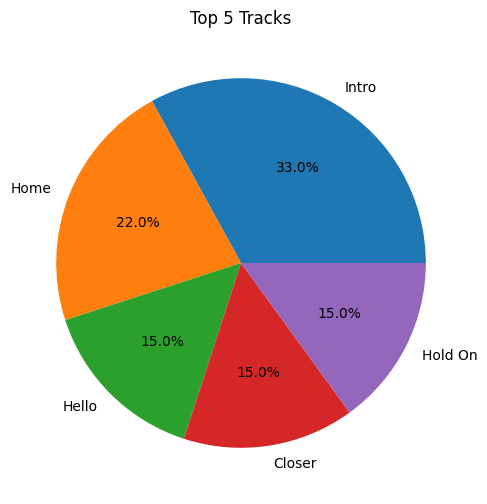

In [12]:
# Convert the PySpark DataFrame to a Pandas DataFrame
top_5_tracks_pd = top_5_tracks.toPandas()

# Create a pie chart
plt.figure(figsize=(10,6))
plt.pie(top_5_tracks_pd['count'], labels=top_5_tracks_pd['track'], autopct='%1.1f%%')
plt.title('Top 5 Tracks')
plt.show()


The track "Intro" is the most popular, with 33% of users listening to it.



## encoding (encode a string columns)

In [13]:
# Create a StringIndexer to encode user and track columns
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
track_indexer = StringIndexer(inputCol="track", outputCol="track_index")

In [14]:
# Fit the StringIndexer models to the data
user_indexer_model = user_indexer.fit(music_df_agg)
track_indexer_model = track_indexer.fit(music_df_agg)

In [16]:
# Transform the data to add the indexed columns
music_df_indexed = user_indexer_model.transform(track_indexer_model.transform(music_df_agg))


In [17]:
music_df_indexed.show()

+-----------+--------------------+-----+-----------+----------+
|    user_id|               track|count|track_index|user_index|
+-----------+--------------------+-----+-----------+----------+
|000Silenced|      Post(?)organic|    1|    18983.0|      14.0|
|000Silenced|    Away In A Manger|    1|     5699.0|      14.0|
|000Silenced|Soul Purge (Featu...|    1|    21583.0|      14.0|
|000Silenced|            Red Heat|    1|    19556.0|      14.0|
|000Silenced|            Headknot|    1|     2238.0|      14.0|
|000Silenced|We Love Bass (Dub...|    1|    25787.0|      14.0|
|000Silenced|Anomaly (Calling ...|    1|     5340.0|      14.0|
|000Silenced|               Rhino|    1|    19718.0|      14.0|
|000Silenced| Let the Story Begin|    1|    15161.0|      14.0|
|000Silenced|Don't Stop The Mu...|    1|     9217.0|      14.0|
|000Silenced|   Can't Tek No More|    1|     1692.0|      14.0|
|000Silenced|               Money|    1|      209.0|      14.0|
|000Silenced|   I'm Not Invisible|    1|

## split the data

In [18]:
# Split the data into training and test sets
(train, test) = music_df_indexed.randomSplit([0.8, 0.2])

## ALS model

ALS is an iterative optimization process where  for every iteration we try to arrive closer and closer to a factorized representation of our original data.

In [19]:
# Create an ALS model
als = ALS(
    maxIter=5,  # Maximum number of iterations to run
    regParam=0.01,  # Regularization parameter
    userCol="user_index",  # Column name for user indices
    itemCol="track_index",  # Column name for item indices
    ratingCol="count",  # Column name for rating
    coldStartStrategy="drop"  # Strategy to deal with unknown users/items at prediction time
)


In [20]:
# Fit the ALS model to the training data
als_model = als.fit(train)

In [60]:
# Generate recommendations for all users
Recs = als_model.recommendForAllUsers(20)

# Show the recommendations
Recs.show()

+----------+--------------------+
|user_index|     recommendations|
+----------+--------------------+
|       210|[{12171, 9.995103...|
|       230|[{10824, 12.80359...|
|       190|[{1515, 9.20861},...|
|       140|[{9275, 17.279867...|
|        20|[{2860, 10.964227...|
|        40|[{83, 18.755627},...|
|       120|[{9275, 8.063115}...|
|       220|[{21840, 7.991742...|
|       100|[{893, 8.446608},...|
|        31|[{10824, 9.937634...|
|       211|[{180, 7.8045025}...|
|       101|[{23734, 8.31857}...|
|        81|[{847, 9.831466},...|
|        91|[{9823, 10.666458...|
|       111|[{83, 17.430952},...|
|         1|[{2860, 9.259633}...|
|       191|[{16635, 7.600222...|
|        41|[{25223, 6.992723...|
|        61|[{83, 16.457142},...|
|       231|[{515, 8.31032}, ...|
+----------+--------------------+
only showing top 20 rows



Map track indices to track names

In [61]:
# "explode" the recommendations
exploded_Recs = Recs.withColumn("rec_exp", expr("explode(recommendations)"))
exploded_Recs.show()

+----------+--------------------+------------------+
|user_index|     recommendations|           rec_exp|
+----------+--------------------+------------------+
|       210|[{12171, 9.995103...| {12171, 9.995103}|
|       210|[{12171, 9.995103...|  {9823, 7.287602}|
|       210|[{12171, 9.995103...|{23034, 7.1309786}|
|       210|[{12171, 9.995103...|{16635, 7.0426383}|
|       210|[{12171, 9.995103...| {13574, 6.996572}|
|       210|[{12171, 9.995103...| {9275, 6.1682324}|
|       210|[{12171, 9.995103...|{26296, 5.9970613}|
|       210|[{12171, 9.995103...|{24166, 5.9970613}|
|       210|[{12171, 9.995103...|{11857, 5.9970613}|
|       210|[{12171, 9.995103...| {7828, 5.9970613}|
|       210|[{12171, 9.995103...| {1012, 5.9819407}|
|       210|[{12171, 9.995103...| {20074, 5.490397}|
|       210|[{12171, 9.995103...| {10844, 5.386526}|
|       210|[{12171, 9.995103...|  {475, 5.2909575}|
|       210|[{12171, 9.995103...|   {231, 5.072632}|
|       210|[{12171, 9.995103...|{26971, 4.997

In [62]:
# Join the exploded recommendations with the original DataFrame to get track names
Recs_joined = exploded_Recs.join(music_df_indexed, exploded_Recs.rec_exp.track_index == music_df_indexed.track_index)


In [63]:
# Create a DataFrame with user_id and the recommended tracks
final_recs = Recs_joined.groupby("user_id").agg(collect_set("track").alias("recommended tracks"))

# Display the DataFrame
final_recs.show()


+---------------+-------------------------------+
|        user_id|             recommended tracks|
+---------------+-------------------------------+
|    000Silenced|           [Mars (Jack Beats...|
|         004545|               [Paint It Black]|
|        00Lemon|           [Creep, All of th...|
|00TrompeLeMonde|           [Have Yourself a ...|
|        00bob00|           [Six Polish Songs...|
|      00fieldsy|           [Tompkins Square ...|
|        00jamez|           [You're Not Alone...|
|    00williamsj|           [Higher Love, Fir...|
|    00williamsl|           [Bloom (Official ...|
|        01Green|[聽見下雨的聲音, 蛇 舞, 珊瑚...|
|     01higginsr|           [Mercy, Do I Wann...|
|     01kaputnik|           [Here, El Mañana,...|
|  01rwsouthgate|           [Airplanes, I Won...|
|       01smicha|           [The Hunter, Pres...|
|      01srainey|           [Tears in Heaven,...|
|     02styles91|           [Circle of Life, ...|
|      03swalker|           [Dancing In The R...|
|        05

Get recommended tracks for a specific user.

In [65]:
# Define a function to get recommended tracks for a specific user.
# Takes user_id (the user for whom recommendations are needed) and recs_dataframe (the DataFrame with recommendations).
def get_recommended_tracks(user_id, recs_dataframe):
    # Filter the DataFrame to select rows with the specified user_id.
    filtered_recs = recs_dataframe.filter(final_recs["user_id"] == user_id)

    # Select the "recommended tracks" column for the filtered user.
    recommended_tracks_list = filtered_recs.select("recommended tracks").collect()[0]["recommended tracks"]

    # Return the list of recommended tracks for the user.
    return recommended_tracks_list


In [66]:
# Define the user ID for which we want to retrieve recommended tracks.
user_id = "000Silenced"

# Call the function get_recommended_tracks with the specified user_id and final_recs DataFrame,
# and store the recommended tracks in the recommended_tracks variable.
recommended_tracks = get_recommended_tracks(user_id, final_recs)

# Print the recommended tracks for the user.
print(recommended_tracks)


['Mars (Jack Beats Remix)', 'Chemical', 'Fenix Funk 5 (Wipeout Edit)', 'On the Brink of Extinction', 'Snot', 'Smartbomb (Plump DJs mix)', 'Shellshock (Featuring Foreign Beggars)', 'Paper Doll']


In [68]:
# try another user
id = "00williamsj"
get_recommended_tracks(id, final_recs)

['Higher Love',
 'Fire Away',
 'Might as Well Get Stoned',
 'Traveller',
 'Runaway',
 'Under Pressure',
 'Nobody to Blame',
 'Tennessee Whiskey',
 'Hellhole',
 'More of You',
 'Ziggy Stardust - 2012 Remastered Version',
 'Boy',
 'Wrecker',
 'Whiskey and You',
 'Such Great Heights',
 "Daddy Doesn't Pray Anymore",
 'Was It 26',
 'Orion',
 'My Marengo',
 'Space Oddity - 2015 Remastered Version']

In [69]:
# try another user
id = "01Green"
get_recommended_tracks(id, final_recs)

['聽見下雨的聲音',
 '蛇 舞',
 '珊瑚海',
 '魔術先生',
 '免費教學錄影帶',
 '小樹',
 '陽光宅男',
 '我沒有',
 '說好的幸福呢',
 'Faded',
 '明明就',
 '退後',
 'Everything',
 '我沒有+Flowers',
 '無雙']

## Evaluate the model
 Assess the predictive accuracy of the ALS model

In [70]:
# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
# Generate predictions on the test data
predictions = als_model.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error = " + str(rmse))

Root Mean Squared Error = 2.0888732511410897


 keep in mind that different applications may require different evaluation metrics, and you should choose the metric that aligns with your specific recommendation goals.